In [3]:
import os, re, sys, random, shutil, cv2
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import segmentation_models as sm 

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model , load_model
from keras.utils import to_categorical, model_to_dot , plot_model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, ZeroPadding2D, Dropout

from keras.optimizers import Adam, Nadam
from keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
root_folder = './data/SemanticSegmentationDataset'

In [6]:
# cut images into 256x256 pieces
img_patch_size = 256

# scale each variable to the range of 0-1
scaler = MinMaxScaler()

In [7]:
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):
    
    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]
    
    if dir_name== 'images':
        print(path)
        
        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()
        
        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'): 
                print('-------------------\n' ,img)
                
                #read images as RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(image.shape)
                
                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_patch_size) * img_patch_size
                sizeY = (image.shape[0] // img_patch_size) * img_patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))
                print(image)
                
                # convert images into numpy array
                image = np.array(image)

                # cut up images into 256x256 pieces
                patched_imgs = patchify(image , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_imgs.shape)
                
                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        # add all patched images to a list
                        img_dataset.append(single_patch_img)

./data/SemanticSegmentationDataset\Tile 1\images
-------------------
 image_part_001.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD588A90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD39E380>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD39E470>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD4EEE90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD39E470>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD39E380>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD39

-------------------
 image_part_003.jpg
(2061, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD5895A0>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
(2062, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58B340>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
(2062, 1816, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58AFB0>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
(2062, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58B010>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
(2061, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58B370>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_008.jpg
(2061, 1816, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58B340>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_009.jpg
(2061, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CD58B010>
(8, 7, 1, 256, 

In [8]:
msk_dataset = [] 

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]
    
    if dirname == 'masks':
        print(path)
        
        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()
        
        
        for i, msk in enumerate(masks_lst):  
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)
               
                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(mask.shape)
                
                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_patch_size)*img_patch_size 
                sizeY = (mask.shape[0]//img_patch_size)*img_patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY)) 
                print(mask)
                
                # convert masks into numpy array
                mask = np.array(mask)             
       
                # cut up masks into 256x256 pieces
                patched_masks = patchify(mask , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_masks.shape)
        
                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):
                        
                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]  
                        
                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask) 

./data/SemanticSegmentationDataset\Tile 1\masks
-------------------
 image_part_001.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD58B040>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD5894B0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD5896F0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD58BC70>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD588970>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD58A860>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x1D2CD58A

(8, 7, 1, 256, 256, 3)
-------------------
 image_part_004.png
(2062, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB4190>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_005.png
(2062, 1816, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB41C0>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_006.png
(2062, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB4220>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_007.png
(2061, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB4280>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_008.png
(2061, 1816, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB4310>
(8, 7, 1, 256, 256, 3)
-------------------
 image_part_009.png
(2061, 1817, 3)
<PIL.Image.Image image mode=RGB size=1792x2048 at 0x1D2CECB41F0>
(8, 7, 1, 256, 256, 3)
./data/SemanticSegmentationDataset\Tile 8\masks
-------------------
 image_part_001.png
(1479, 2149, 3)
<PIL.Imag

In [9]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

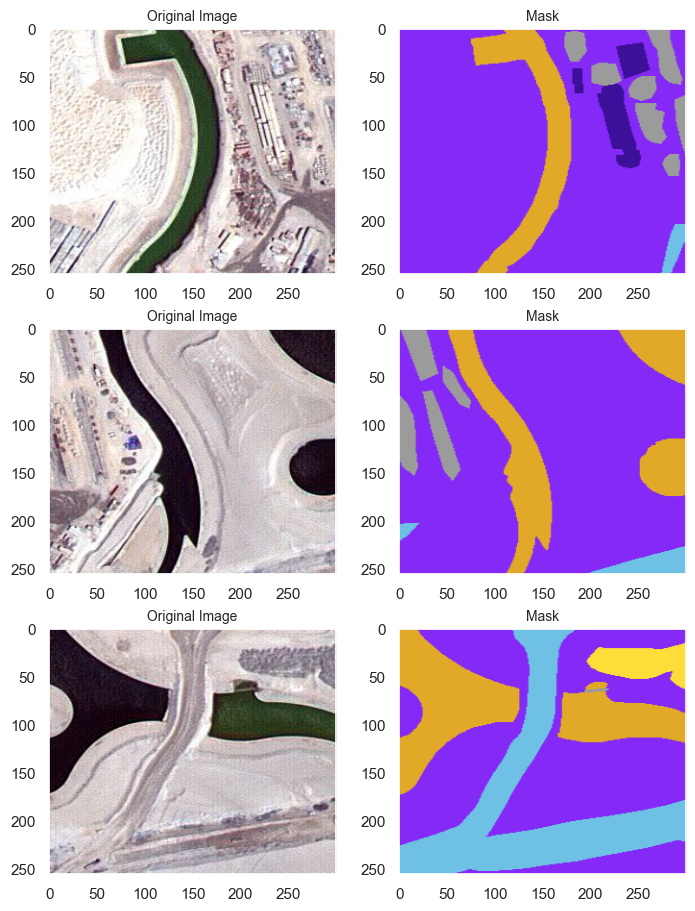

In [10]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(7, 9), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (300,256)))
        axs[count][0].set_title('Original Image', fontdict = {'fontsize':10})
        axs[count][0].grid(False)
        axs[count][0].axis(True)
        
        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (300,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].grid(False)
        axs[count][1].axis(True)
        
        count +=1
    i += 1
    if (count==3):
        break
        
plt.show()

In [11]:
# Convert HEX labels to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) 
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) 
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]


In [12]:
def rgb_to_2D_label(msk_dt):

    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)
    
    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5
    
    # just take the first channel
    label_seg = label_seg[:,:,0]  
    
    return label_seg

In [13]:
labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

In [14]:
labels = np.array(labels) 
print(labels.shape)
labels

(1305, 256, 256)


array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 5, 5, ..., 4, 4, 4],
        [1, 5, 5, ..., 4, 4, 4],
        [1, 1, 5, ..., 4, 4, 4],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       [[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 

In [15]:
labels = np.expand_dims(labels, axis=3)
labels.shape

(1305, 256, 256, 1)

In [16]:
# one-hot-ecoding
print("all labels : ", np.unique(labels))
n_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=n_classes)
labels_cat

all labels :  [0 1 2 3 4 5]


array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.

In [17]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1044, 256, 256, 3)
(261, 256, 256, 3)
(1044, 256, 256, 6)
(261, 256, 256, 6)


In [18]:
# config
img_height = X_train.shape[1] #256
img_width = X_train.shape[2] #256
img_channels = X_train.shape[3] #3

In [7]:
#class_weights = compute_class_weight(
                                        #class_weight = "balanced",
                                        #classes = np.unique(np.ravel(labels,order='C')),
                                        #y = np.ravel(labels,order='C')                                                    
                                    #)

# use equal weights
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [8]:
# metrics
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return ((2* And + 1.0) / (K.sum(y_truef) + K.sum(y_predf) + 1.0)) 


metrics=['accuracy', dice_coef]

# loss function 
dice_loss = sm.losses.DiceLoss(class_weights = weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [42]:
# U-net model 1

def multi_unet(n_classes = n_classes, img_height=img_height, img_width=img_width, img_channels=img_channels):
    
    inputs = Input((img_height, img_width, img_channels))
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2) 
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8) 
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9) 
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [44]:
model_1 = multi_unet()
model_1.compile(optimizer='adam', loss=total_loss, metrics=metrics)

model_1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 256, 256, 16  0           ['conv2d_95[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_109 (Conv2D)            (None, 128, 128, 32  18464       ['concatenate_22[0][0]']         
                                )                                                                 
                                                                                                  
 dropout_52 (Dropout)           (None, 128, 128, 32  0           ['conv2d_109[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_110 (Conv2D)            (None, 128, 128, 32  9248        ['dropout_52[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_tr

In [45]:
history1 = model_1.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 25, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/25
66/66 [==============================] - 337s 5s/step - loss: 0.9985 - accuracy: 0.5207 - dice_coef: 0.4037 - val_loss: 0.9881 - val_accuracy: 0.6264 - val_dice_coef: 0.4984
Epoch 2/25
66/66 [==============================] - 344s 5s/step - loss: 0.9762 - accuracy: 0.6398 - dice_coef: 0.5321 - val_loss: 0.9625 - val_accuracy: 0.7174 - val_dice_coef: 0.6094
Epoch 3/25
66/66 [==============================] - 352s 5s/step - loss: 0.9575 - accuracy: 0.7137 - dice_coef: 0.6239 - val_loss: 0.9608 - val_accuracy: 0.7069 - val_dice_coef: 0.6525
Epoch 4/25
66/66 [==============================] - 364s 6s/step - loss: 0.9475 - accuracy: 0.7402 - dice_coef: 0.6695 - val_loss: 0.9572 - val_accuracy: 0.7195 - val_dice_coef: 0.6740
Epoch 5/25
66/66 [==============================] - 327s 5s/step - loss: 0.9429 - accuracy: 0.7523 - dice_coef: 0.6871 - val_loss: 0.9590 - val_accuracy: 0.7181 - val_dice_coef: 0.6755
Epoch 6/25
66/66 [==============================] - 311s 5s/step - loss: 0.

In [46]:
df_result = pd.DataFrame(history1.history)
df_result

loss  accuracy  dice_coef  val_loss  val_accuracy  val_dice_coef
0   0.998533  0.520688   0.403667  0.988089      0.626387       0.498419
1   0.976236  0.639766   0.532141  0.962548      0.717374       0.609400
2   0.957519  0.713711   0.623854  0.960774      0.706925       0.652518
3   0.947547  0.740185   0.669467  0.957182      0.719455       0.674013
4   0.942885  0.752270   0.687083  0.959002      0.718104       0.675503
5   0.937787  0.768397   0.708319  0.949098      0.746916       0.701202
6   0.932915  0.786136   0.729401  0.942348      0.768074       0.711975
7   0.929589  0.795937   0.740010  0.947910      0.758114       0.714904
8   0.927458  0.803197   0.749974  0.944103      0.766711       0.728650
9   0.923044  0.814429   0.764122  0.945775      0.760809       0.726606
10  0.921735  0.816869   0.767662  0.941450      0.766655       0.728397
11  0.920269  0.821122   0.772709  0.944051      0.761193       0.726051
12  0.919210  0.823219   0.775640  0.935043      0.782401       0.745509
13  0.918241  0.825517   0.778834  0.932279      0.791985       0.755278
14  0.917397  0.827345   0.781710  0.928160      0.800686       0.762204
15  0.915900  0.831418   0.786457  0.928325      0.799261       0.760438
16  0.914749  0.833341   0.789780  0.925140      0.809035       0.771068
17  0.913601  0.836422   0.793381  0.929412      0.795874       0.760300
18  0.912406  0.838932   0.797500  0.929977      0.795444       0.760479
19  0.911575  0.840912   0.799790  0.921939      0.815782       0.778068
20  0.911216  0.841212   0.801118  0.921545      0.818801       0.780666
21  0.911296  0.840874   0.800571  0.925153      0.810242       0.774286
22  0.911452  0.840894   0.800159  0.927891      0.801290       0.763194
23  0.909652  0.844297   0.806299  0.926142      0.806399       0.771601
24  0.913431  0.835542   0.794960  0.936725      0.775702       0.745770

In [58]:
# evalute model 1
loss, acc, dice_loss = model_1.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc)

9/9 [==============================] - 10s 1s/step - loss: 0.9357 - accuracy: 0.7757 - dice_coef: 0.7299
accuracy: 0.7757018804550171


<AxesSubplot: >

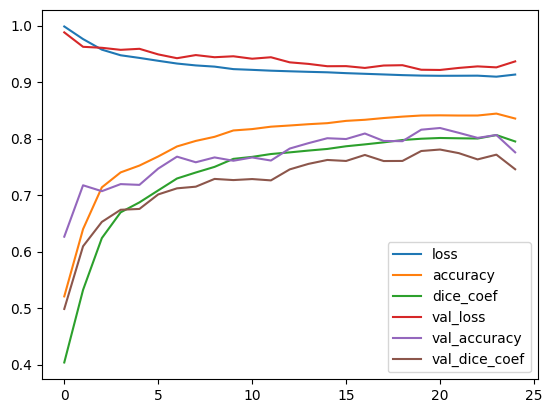

In [59]:
pd.DataFrame(history1.history).plot()

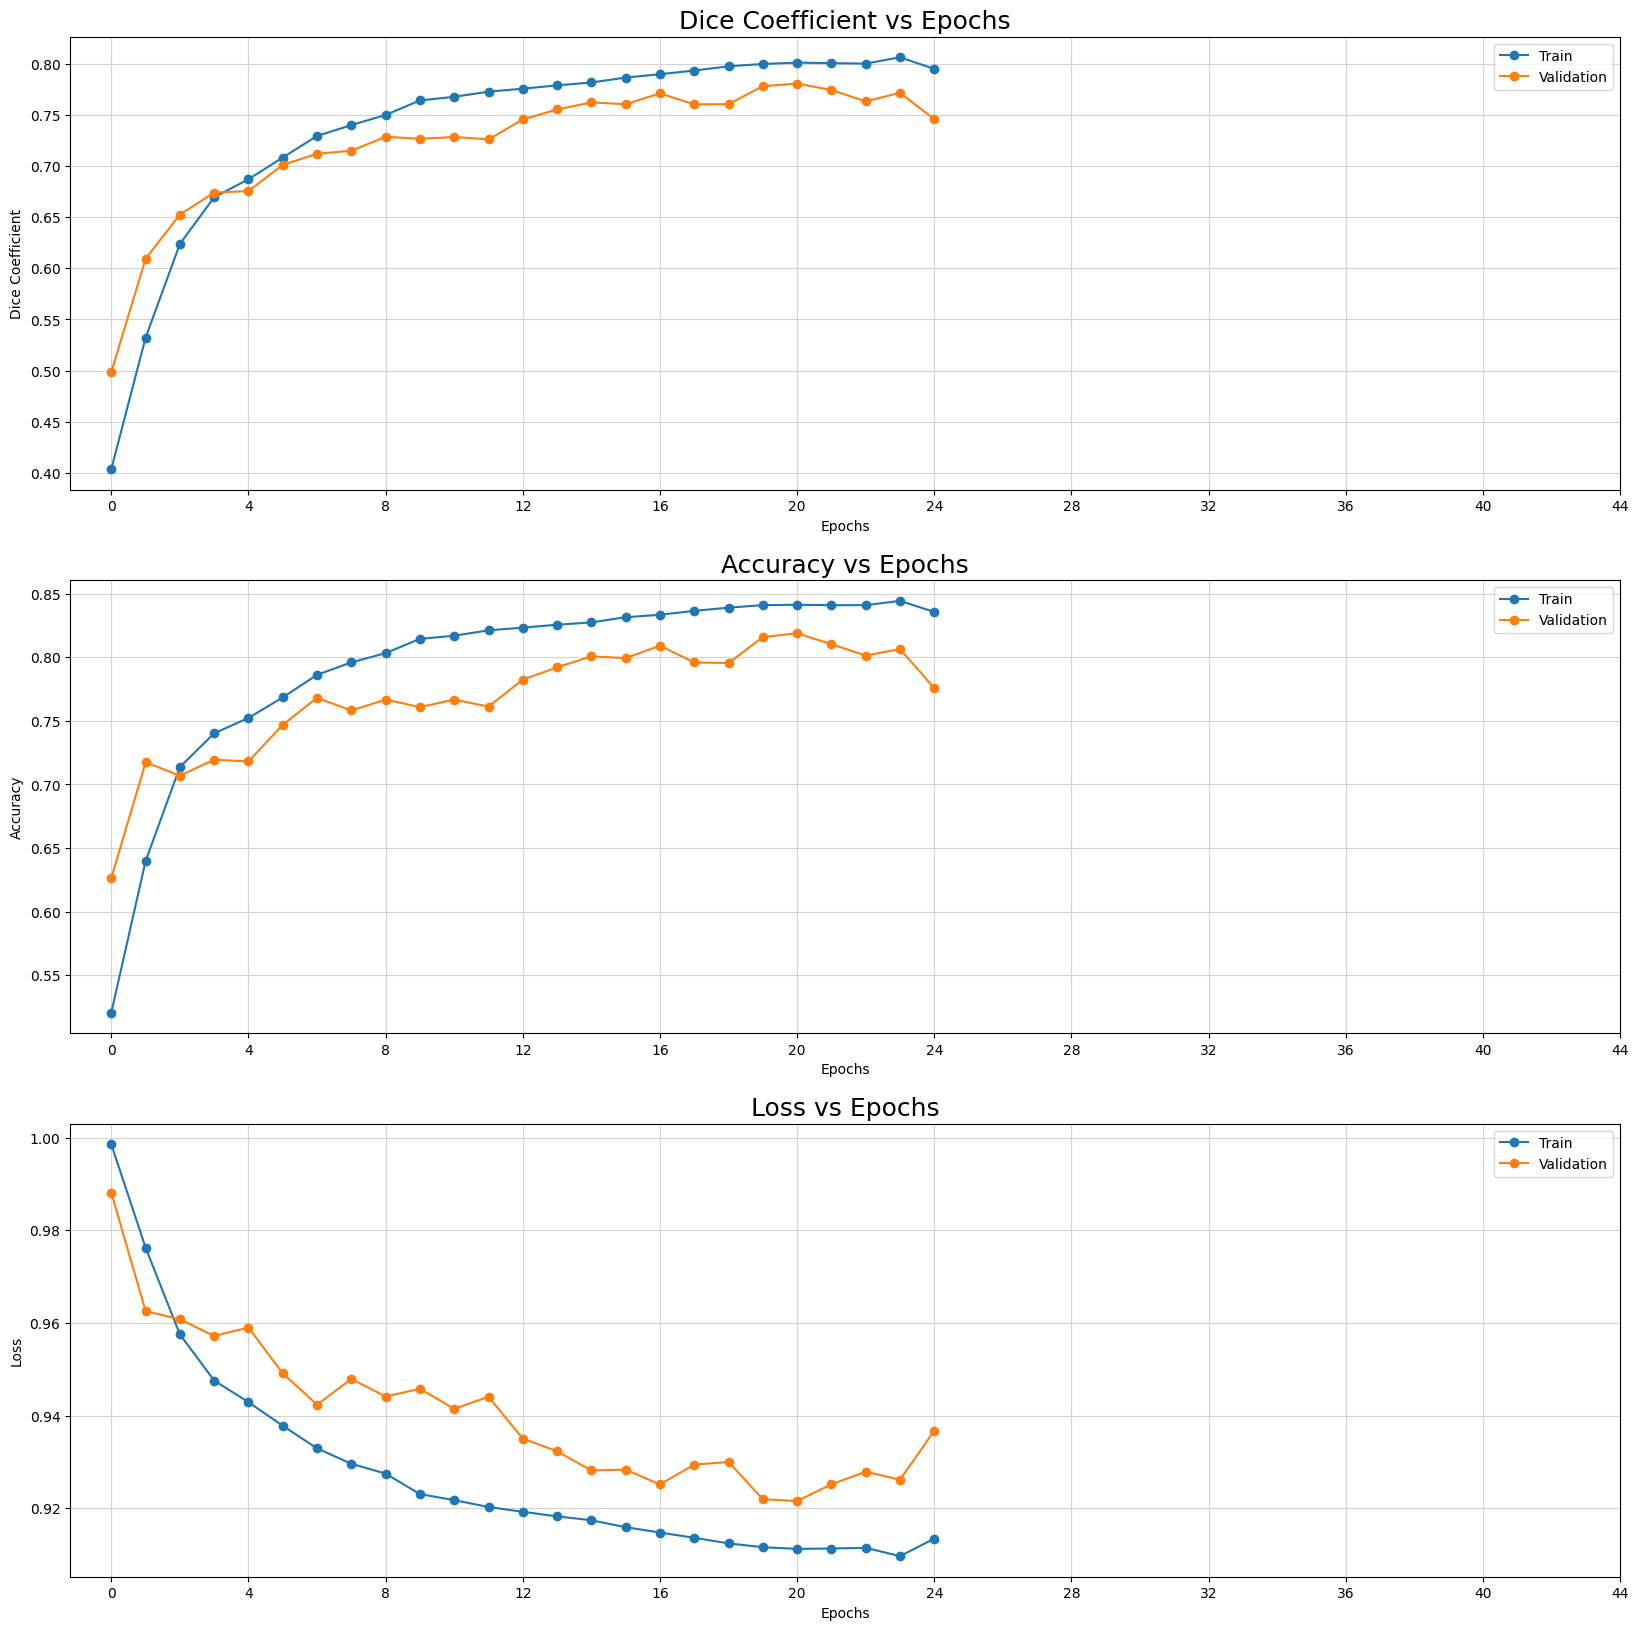

In [75]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss']): 
    ax[i].plot(history1.history[met], 'o-')
    ax[i].plot(history1.history['val_' + met], 'o-')
    ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")    



In [67]:
model_1.save("./models/Multiclass_Unet_Model.h5")

In [91]:
y_pred=model_1.predict(X_test)

9/9 [==============================] - 9s 959ms/step


In [118]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3) 

1/1 [==============================] - 0s 49ms/step


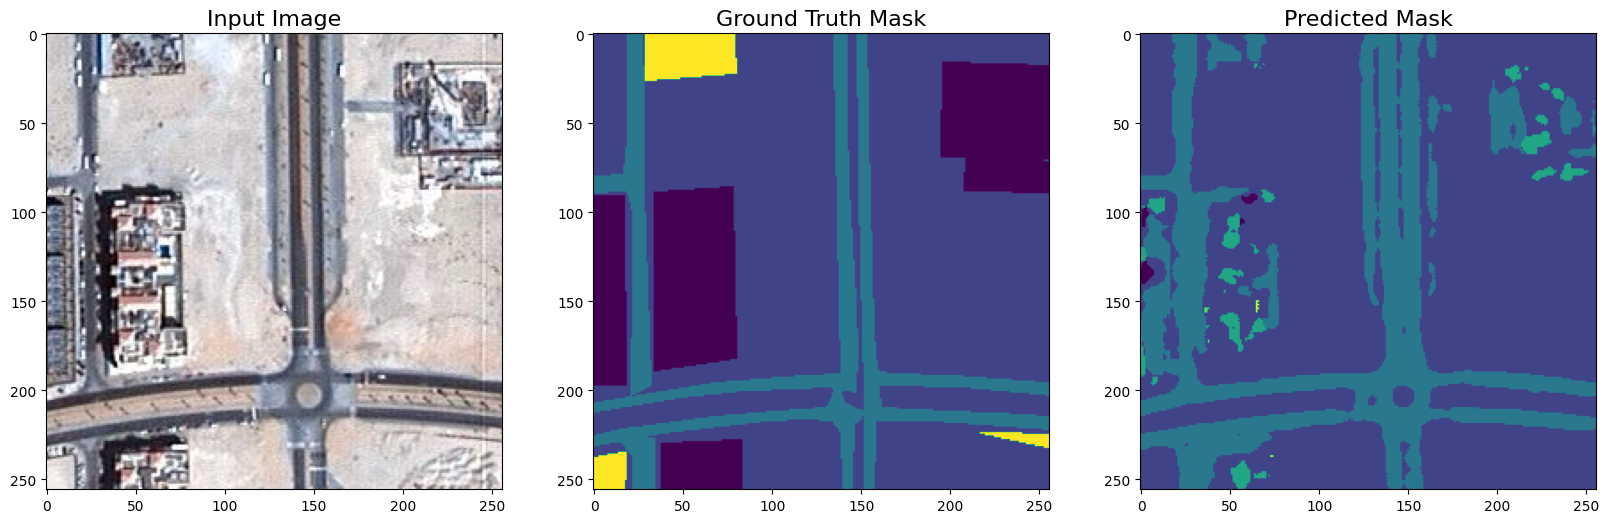

1/1 [==============================] - 0s 49ms/step


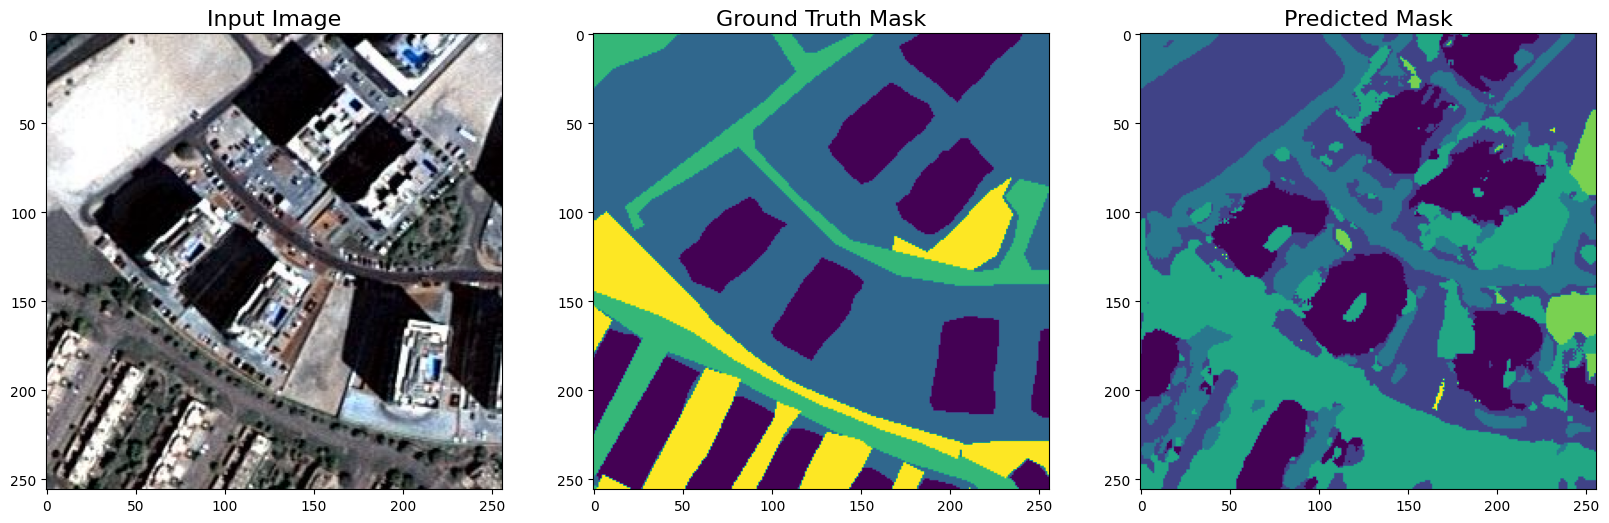

1/1 [==============================] - 0s 50ms/step


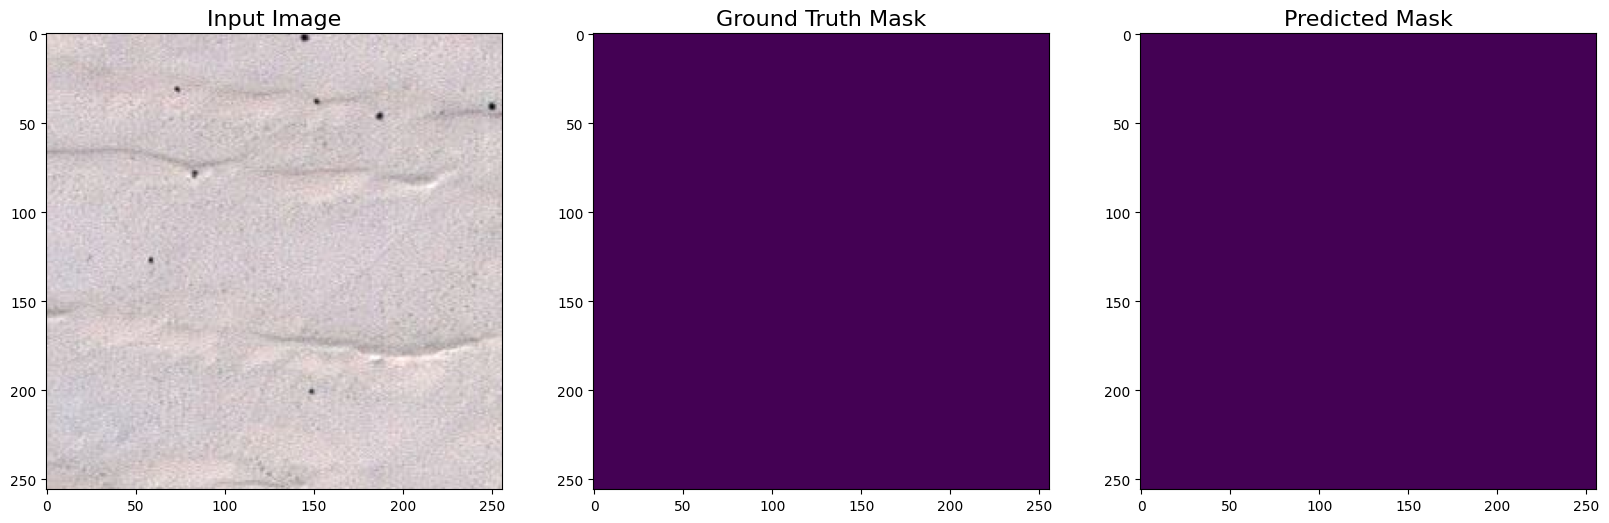

1/1 [==============================] - 0s 48ms/step


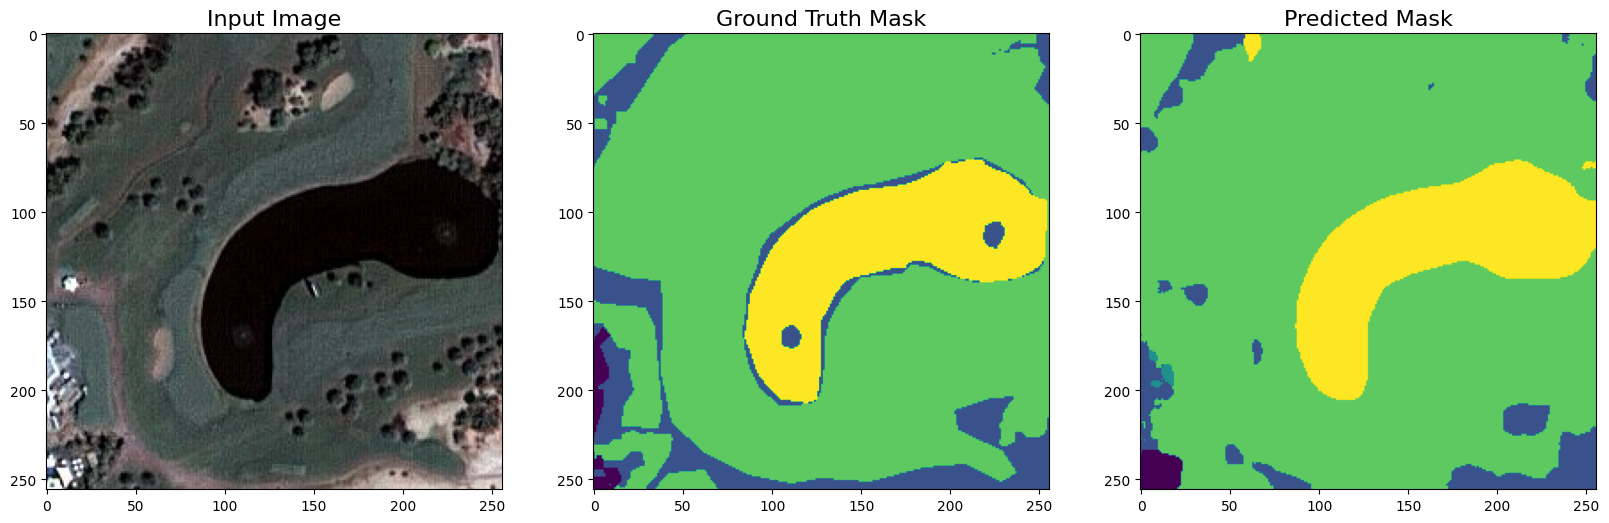

In [115]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(model_1.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
        
    plt.show()

In [42]:
# U-net model 2
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

In [43]:
def decoding_block(inputs, skip_connection_input, filters):
    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
  
    return C

In [44]:
def unet_model(input_size, filters, n_classes):
    inputs = Input(input_size)
        
    # Encoder
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Decoder
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='softmax', padding='same')(C10)
    
    model = Model(inputs=inputs, outputs=C11)

    return model

In [45]:
model2 = unet_model((img_height, img_width, img_channels), filters=32, n_classes=n_classes)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 256, 256, 32  128        ['conv2d_80[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 batch_normalization_80 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_80 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 conv2d_89 (Conv2D)             (None, 16, 16, 512)  2359808     ['activation_80[0][0]']          
                                                                                                  
 batch_normalization_81 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_89[0][0]']              
 ormalization)                                                                                    
          

 conv2d_96 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_19[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_88 (BatchN  (None, 256, 256, 32  128        ['conv2d_96[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_88 (Activation)     (None, 256, 256, 32  0           ['batch_normalization_88[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 256, 256, 32  9248        ['activation_88[0][0]']          
          

In [46]:
model2.compile(optimizer = 'adam', loss = total_loss , metrics = ['accuracy', dice_coef])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

In [47]:
history2 = model2.fit(X_train, y_train, batch_size = 32, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = [callback, reduce_lr], shuffle=True)

Epoch 1/30
33/33 [==============================] - 922s 28s/step - loss: 0.9597 - accuracy: 0.6846 - dice_coef: 0.5840 - val_loss: 1.5458 - val_accuracy: 0.1470 - val_dice_coef: 0.1588 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - 922s 28s/step - loss: 0.9369 - accuracy: 0.7679 - dice_coef: 0.7073 - val_loss: 1.2395 - val_accuracy: 0.1635 - val_dice_coef: 0.1736 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - 947s 29s/step - loss: 0.9280 - accuracy: 0.7932 - dice_coef: 0.7387 - val_loss: 1.2001 - val_accuracy: 0.1930 - val_dice_coef: 0.2011 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - 994s 30s/step - loss: 0.9247 - accuracy: 0.8020 - dice_coef: 0.7474 - val_loss: 0.9986 - val_accuracy: 0.6281 - val_dice_coef: 0.5820 - lr: 0.0010
Epoch 5/30
33/33 [==============================] - 907s 27s/step - loss: 0.9241 - accuracy: 0.8020 - dice_coef: 0.7498 - val_loss: 1.0217 - val_accuracy: 0.5975 - val_dice_coef: 0.5473 - lr: 0.0010
Epoch

In [48]:
df_result2 = pd.DataFrame(history2.history)
df_result2

loss  accuracy  dice_coef  val_loss  val_accuracy  val_dice_coef  \
0   0.959723  0.684625   0.584006  1.545795      0.147035       0.158791   
1   0.936871  0.767908   0.707312  1.239522      0.163485       0.173615   
2   0.927965  0.793195   0.738688  1.200150      0.193012       0.201129   
3   0.924741  0.802023   0.747405  0.998603      0.628124       0.581994   
4   0.924085  0.802000   0.749825  1.021676      0.597538       0.547272   
5   0.921042  0.810427   0.756255  1.021819      0.618464       0.566987   
6   0.917910  0.819679   0.769772  0.985519      0.661000       0.610487   
7   0.917037  0.820653   0.772152  0.961631      0.715122       0.655160   
8   0.916866  0.821085   0.774104  0.988769      0.515011       0.468469   
9   0.915421  0.822618   0.774955  0.929626      0.790796       0.721785   
10  0.914229  0.826751   0.784274  0.929550      0.796924       0.735411   
11  0.912899  0.828833   0.787964  0.931976      0.769467       0.657838   
12  0.915123  0.824841   0.781733  0.922336      0.807008       0.747027   
13  0.911410  0.832340   0.793694  0.922024      0.803719       0.745000   
14  0.912803  0.830634   0.790597  0.926137      0.788745       0.735461   
15  0.910784  0.833026   0.796577  0.919949      0.819297       0.771068   
16  0.910304  0.834983   0.797055  0.927202      0.787871       0.738995   
17  0.909248  0.837373   0.798752  0.914364      0.820563       0.765413   
18  0.909014  0.838472   0.802424  0.915674      0.818139       0.767479   
19  0.907279  0.841622   0.806827  0.909370      0.838687       0.780259   
20  0.908570  0.839190   0.802207  0.946112      0.602689       0.557842   
21  0.913002  0.827082   0.789695  0.930773      0.791200       0.722305   
22  0.908650  0.838240   0.800865  0.911140      0.837046       0.789282   
23  0.907365  0.840550   0.806341  0.905288      0.847826       0.793323   
24  0.908402  0.839438   0.802793  0.904653      0.854063       0.798814   
25  0.908016  0.840836   0.804726  0.965920      0.671856       0.640002   
26  0.905059  0.847142   0.811828  0.908763      0.839511       0.797806   
27  0.905172  0.844651   0.810606  0.913182      0.825089       0.778684   
28  0.908045  0.839363   0.804768  0.923108      0.796128       0.749423   
29  0.905043  0.844486   0.808788  0.912466      0.835161       0.787227   

       lr  
0   0.001  
1   0.001  
2   0.001  
3   0.001  
4   0.001  
5   0.001  
6   0.001  
7   0.001  
8   0.001  
9   0.001  
10  0.001  
11  0.001  
12  0.001  
13  0.001  
14  0.001  
15  0.001  
16  0.001  
17  0.001  
18  0.001  
19  0.001  
20  0.001  
21  0.001  
22  0.001  
23  0.001  
24  0.001  
25  0.001  
26  0.001  
27  0.001  
28  0.001  
29  0.001

In [52]:
# evalute model 2
loss2,acc2,dice_loss2= model2.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc2)

9/9 [==============================] - 39s 4s/step - loss: 0.9125 - accuracy: 0.8352 - dice_coef: 0.7872
accuracy: 0.8351607322692871


<AxesSubplot: >

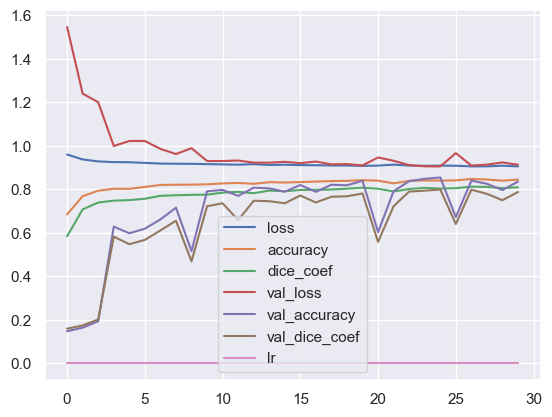

In [53]:
pd.DataFrame(history2.history).plot()

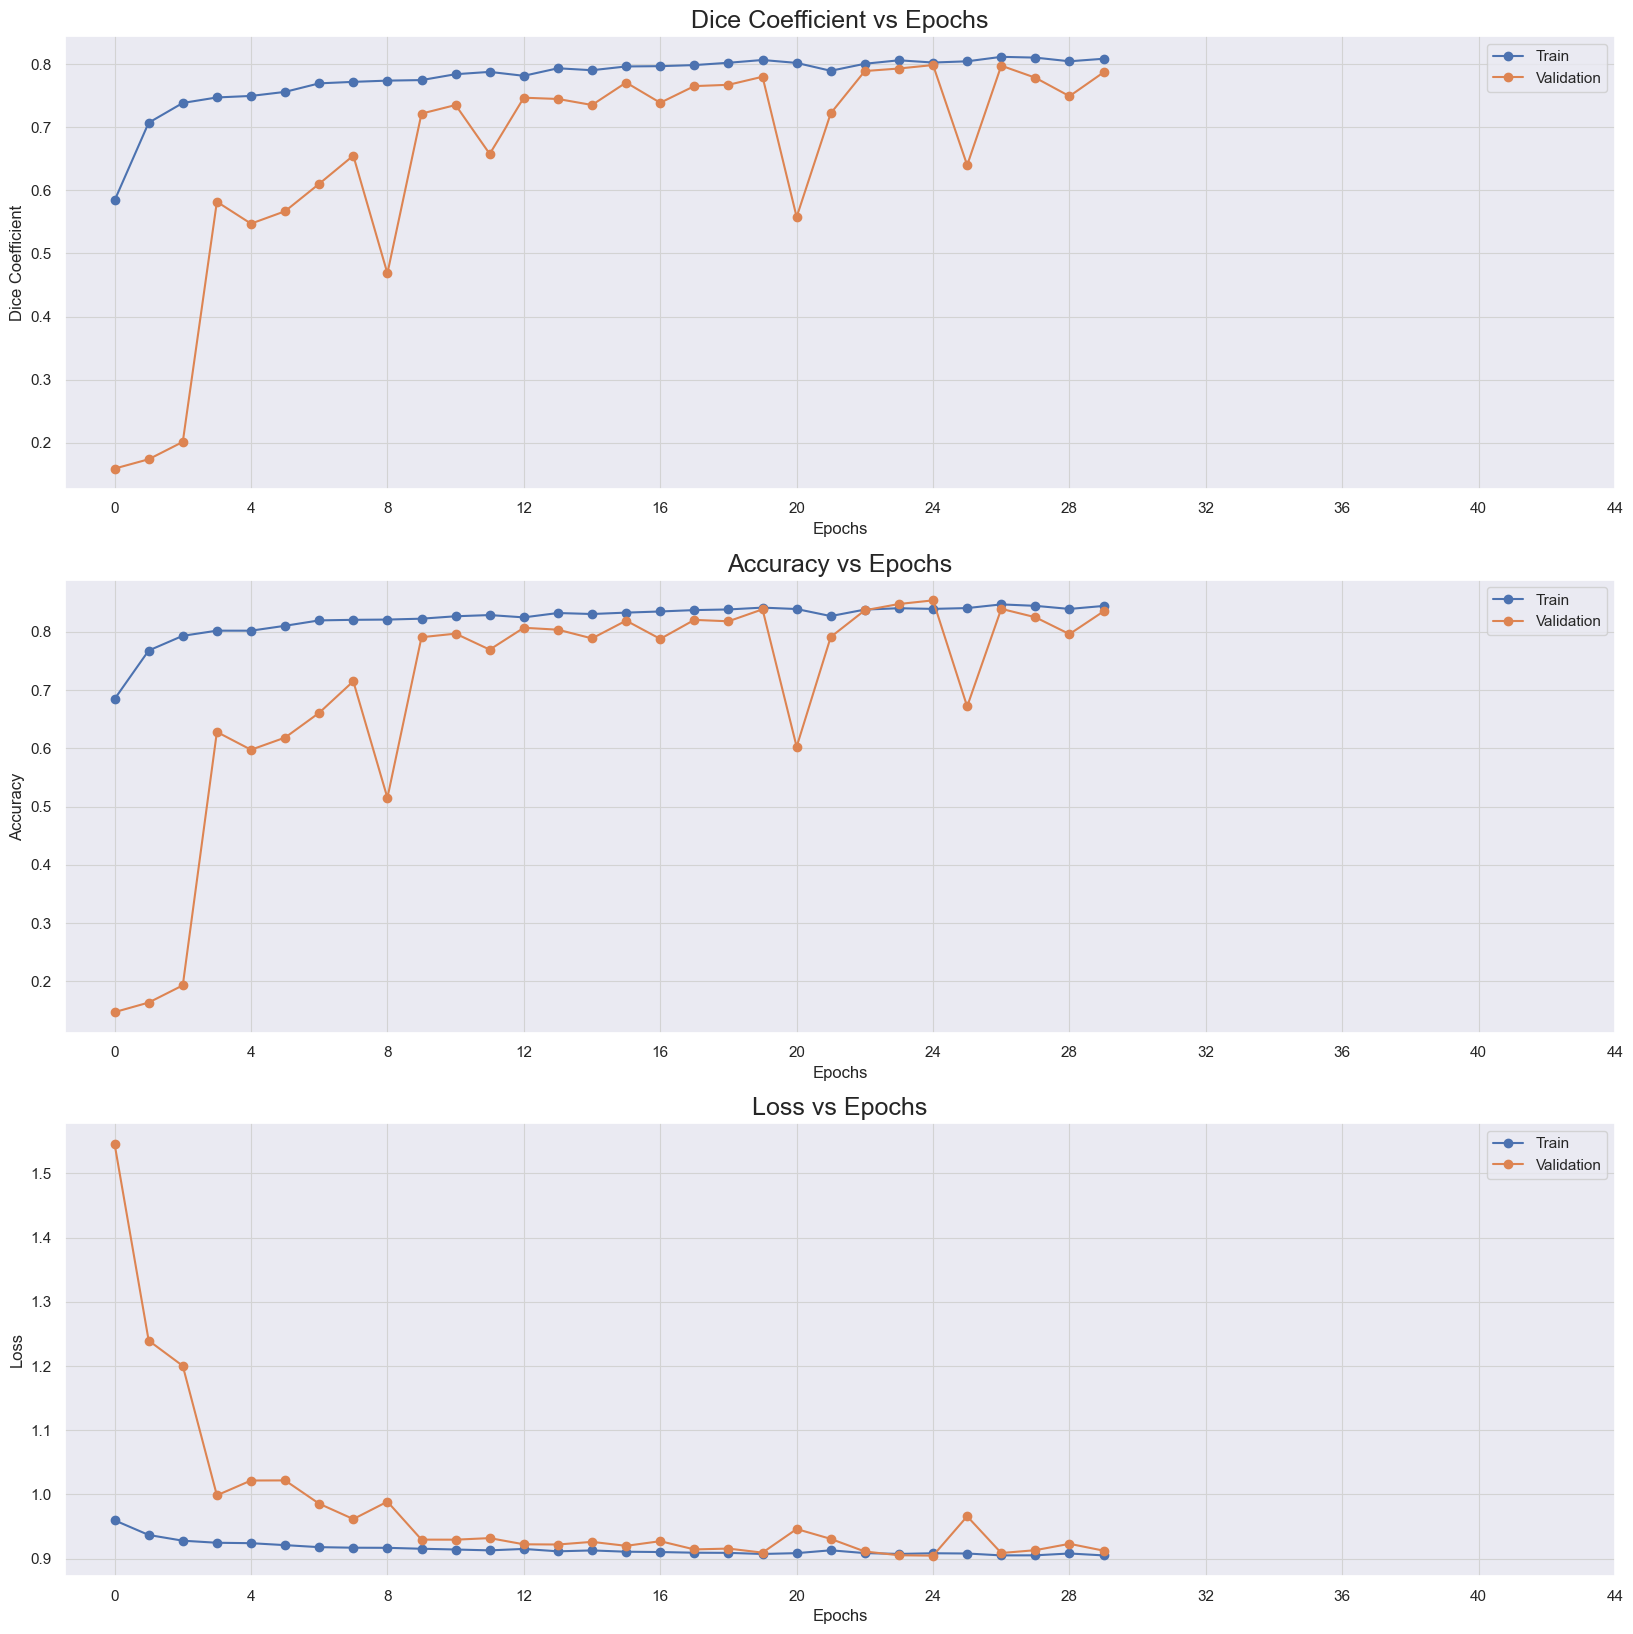

In [54]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss']): 
    ax[i].plot(history2.history[met], 'o-')
    ax[i].plot(history2.history['val_' + met], 'o-')
    ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")   

In [55]:
model2.save("./models/Multiclass_Unet_Model_2.h5")

In [56]:
y_pred2=model2.predict(X_test)

9/9 [==============================] - 37s 4s/step


In [59]:
y_pred2_argmax=np.argmax(y_pred2, axis=3)
y_test_argmax=np.argmax(y_test, axis=3) 

1/1 [==============================] - 0s 155ms/step


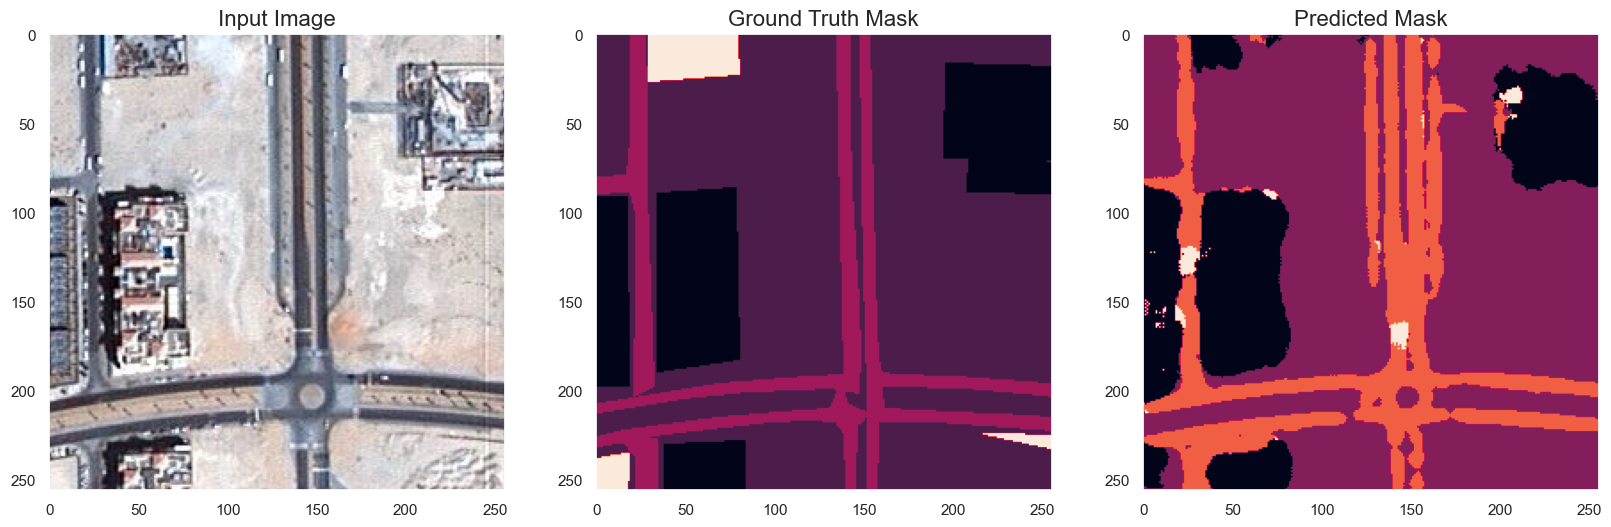

1/1 [==============================] - 0s 158ms/step


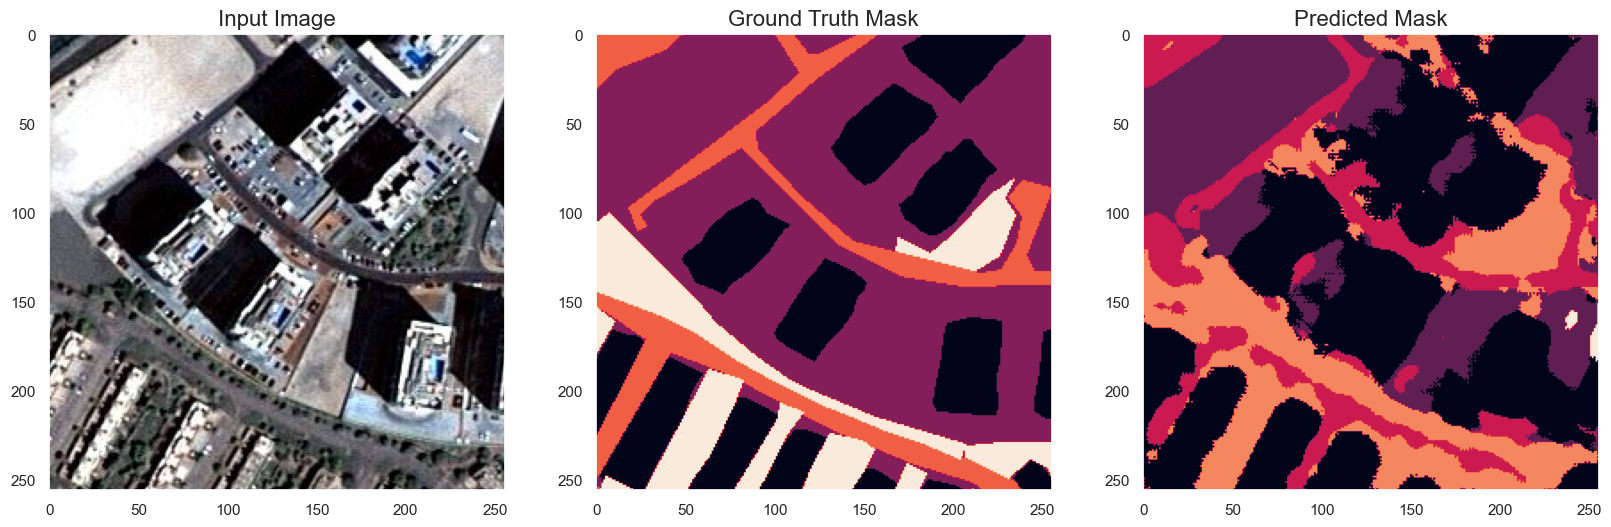

1/1 [==============================] - 0s 168ms/step


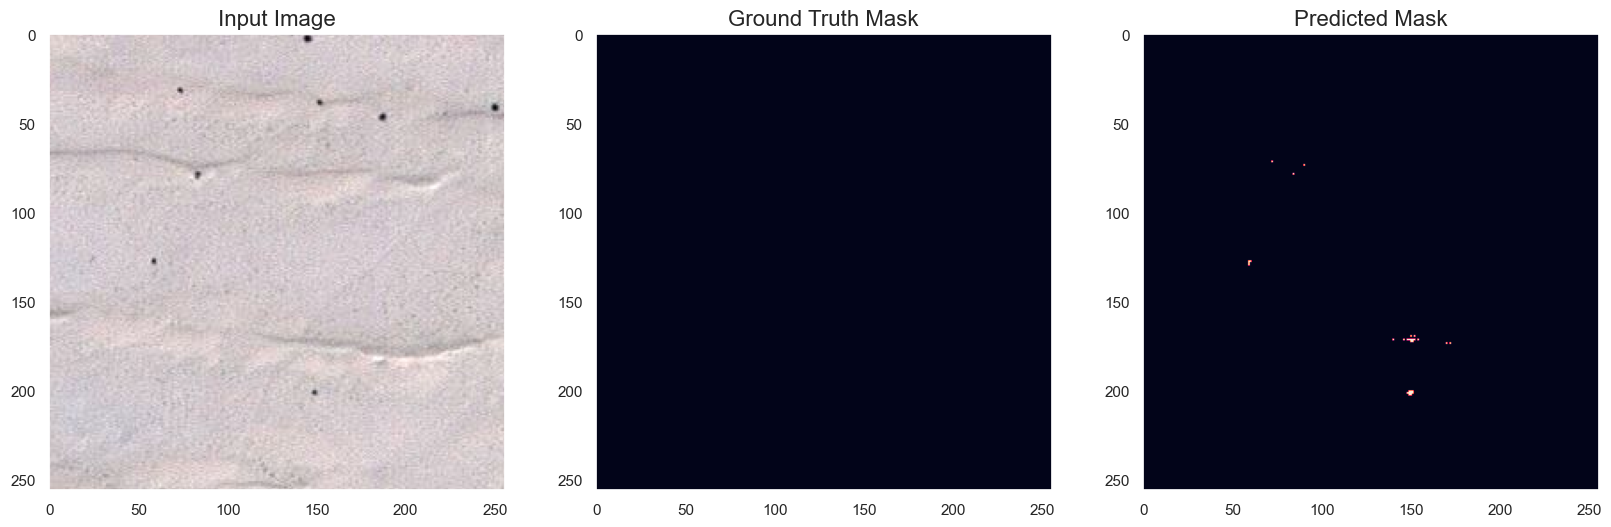

1/1 [==============================] - 0s 166ms/step


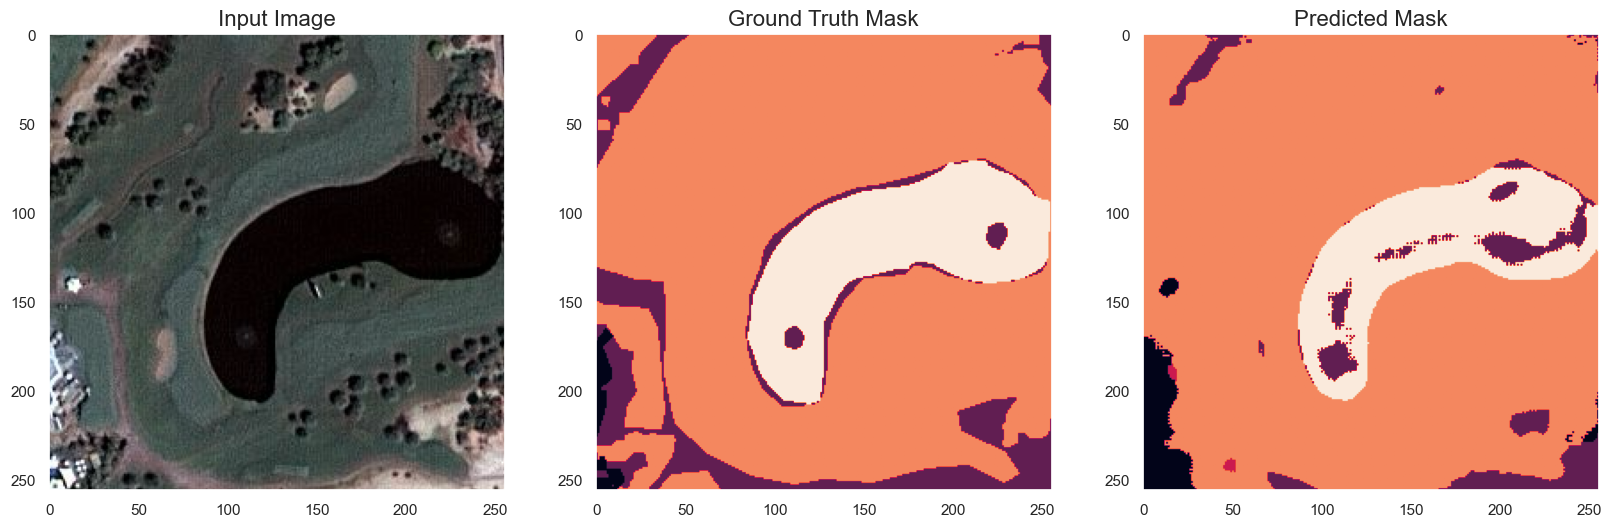

In [65]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])
    ax2.grid(False)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(model2.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax3.grid(False)
        
    plt.show()